In [1]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(X_test)
    auc = metrics.roc_auc_score(y_test,predictions)
    precison = metrics.precision_score(y_test,predictions,average='micro')
    recall = metrics.recall_score(y_test, predictions, average='micro')
    print('Model Performance')
    print('Precision scroe = {:0.4f}.' .format(precison))
    print('Recall scroe = {:0.4f}.' .format(recall))
    print('ROC AUC scroe = {:0.4f}.' .format(auc))
    return auc

In [2]:
from __future__ import division,print_function

%load_ext autoreload

%autoreload 2


import logging
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
#import radiomics
import six

#import torch
#import skimage 
#import cv2
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve, auc, roc_curve, recall_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score


%matplotlib inline  
 

# # Get the PyRadiomics logger (default log-level = INFO)
# logger = radiomics.logger
# logger.setLevel(logging.DEBUG)  # set level to DEBUG to include debug log messages in log file

# # Write out all log entries to a file
# handler = logging.FileHandler(filename='testLog.txt', mode='w')
# formatter = logging.Formatter('%(levelname)s:%(name)s: %(message)s')
# handler.setFormatter(formatter)
# logger.addHandler(handler)

# data_path = 'G:/StrokeResearch/stroke_MRI/region_based/'

In [3]:
def Find_Optimal_Cutoff(target, predicted):
        """ Find the optimal probability cutoff point for a classification model related to event rate
        Parameters
        ----------
        target : Matrix with dependent or target data, where rows are observations
        predicted : Matrix with predicted data, where rows are observations
        Returns
        -------
        list type, with optimal cutoff value
        """
        fpr, tpr, threshold = roc_curve(target, predicted)

        best_threshold_idx = np.argmax(tpr-fpr)
        best_threshold = threshold[best_threshold_idx]
        return best_threshold

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from pprint import pprint

## merge with label

# read in radiomics data
# radiomics = pd.read_csv('G:/StrokeResearch/TICI_radiomics_paper/radiomics_features.csv')
# clinical_set = pd.read_csv('G:/StrokeResearch/TICI_radiomics_paper/eligible_IR_patients_MR.csv')

# # merge filename, label by filename
# radiomics = pd.merge(radiomics,clinical_set[['pic_ID','TICI_B']].dropna(), on='pic_ID')
# X = radiomics.drop(['pic_ID','TICI_B'],1)
# Y = radiomics[['TICI_B']].astype(int).values.ravel()

features = pd.read_csv('features_w_mTICI.csv')
radiomics = features.loc[:,features.columns != 'Label_mTICI_2c+'].columns

X= features[radiomics]
Y= features['Label_mTICI_2c+']


# create train test dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=8)



In [5]:
# feature selection LASSO
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear'))
sel_.fit(scaler.transform(X_train), y_train)
selected_feat_LASSO = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat_LASSO)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))
# LASSO selected features
X_train_selected_LASSO = sel_.transform(X_train)
X_test_selected_LASSO = sel_.transform(X_test)

total features: 1224
selected features: 21
features with coefficients shrank to zero: 1203


(485,)


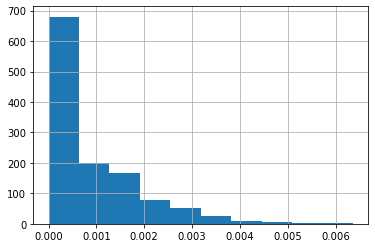

In [6]:
# feature selection RF
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict

# merge filename, label by filename
rf = RandomForestClassifier()
scores = defaultdict(list)

cls = RandomForestClassifier(max_depth=110, max_features=3, min_samples_leaf=4,min_samples_split=8, n_estimators=500)
sel = SelectFromModel(cls)
sel.fit(X_train, y_train)
selected_feat_rf= X_train.columns[(sel.get_support())]
print(selected_feat_rf.shape)
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

In [7]:
from sklearn.manifold import TSNE
pca = PCA(n_components=5,svd_solver='full')
pca_result_train = pca.fit_transform(X_train)
pca_result_test = pca.fit_transform(X_test)

In [34]:
# Run classifier with cross-validation and plot ROC curves

#classifier = AdaBoostClassifier(learning_rate = 0.5, n_estimators=200)
# classifier = RandomForestClassifier(max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50)
classifier = SVC(C=300, kernel='rbf', gamma=0.0001, probability=True)
#classifier = KNeighborsClassifier(n_neighbors=10, weights='distance',n_jobs=4)
#classifier = LogisticRegression(C=0.1, penalty='l2',solver='saga',max_iter=500,random_state=i,class_weight='balanced',n_jobs=4)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

# X_RF
# X_s =X_train[selected_feat_rf]
# X_t = X_test[selected_feat_rf]
feat_train_sc=scaler.fit_transform(X_train[selected_feat_rf])
feat_test_sc= scaler.fit_transform(X_test[selected_feat_rf])
X_s = pd.DataFrame(feat_train_sc)
X_t = pd.DataFrame(feat_test_sc)


# X_LASSO
# X_s = X_train[selected_feat_LASSO]
# X_t = X_test[selected_feat_LASSO]
# feat_train_sc=scaler.fit_transform(X_train[selected_feat_LASSO])
# feat_test_sc= scaler.fit_transform(X_test[selected_feat_LASSO])
# X_s = pd.DataFrame(feat_train_sc)
# X_t = pd.DataFrame(feat_test_sc)

# X_PCA
# pca_result_train = pca.fit_transform(scaler.fit_transform(X_train))
# pca_result_test = pca.fit_transform(scaler.fit_transform(X_test))
# X_s = pd.DataFrame(pca_result_train)
# X_t = pd.DataFrame(pca_result_test)

auc_ML = []
sens_ML = []
spec_ML = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

#classifier = RandomForestClassifier(max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50)
for i in range(100):
    cv = StratifiedKFold(n_splits=5,shuffle=False)
    for j, (train, test) in enumerate(cv.split(X_s, y_train)):
        apple = X_s.iloc[train]
        orange = y_train.iloc[train]
        classifier.fit(apple, orange)
    
    y_pred = classifier.predict_proba(X_t)[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    threshold = Find_Optimal_Cutoff(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, (y_pred >= threshold)).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    auc_ML.append(auc)
    sens_ML.append(sensitivity)
    spec_ML.append(specificity)

In [31]:
mean_auc = np.mean(auc_ML)
sd_auc = 1.96*np.std(auc_ML)/np.sqrt(len(auc_ML))
mean_sens = np.mean(sens_ML)
sd_sens = 1.96*np.std(sens_ML)/np.sqrt(len(sens_ML))
mean_spec = np.mean(spec_ML)
sd_spec = 1.96*np.std(spec_ML)/np.sqrt(len(spec_ML))
mean_auc = "{:.2%}".format(mean_auc)
sd_auc = "{:.2%}".format(sd_auc)
mean_sens = "{:.2%}".format(mean_sens)
sd_sens = "{:.2%}".format(sd_sens)
mean_spec = "{:.2%}".format(mean_spec)
sd_spec = "{:.2%}".format(sd_spec)
print("auc: %s +/- %s" % (mean_auc,sd_auc))
print("sensitivity: %s +/- %s" % (mean_sens,sd_sens))
print("specificity: %s +/- %s" % (mean_spec,sd_spec))

auc: 0.00% +/- 0.00%
sensitivity: 0.00% +/- 0.00%
specificity: 100.00% +/- 0.00%


In [32]:
tprs_rf = tprs

tprs_svm = tprs

tprs_lr = tprs

tprs_knn = tprs

<ipython-input-33-f66c80cc9a68>:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


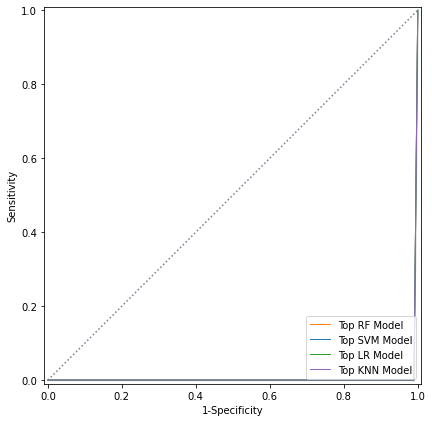

In [33]:
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(6, 6))

# RF
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
std_tpr_rf = 1.96*np.std(tprs_rf, axis=0)/10
tprs_upper_rf = np.minimum(mean_tpr_rf + std_tpr_rf, 1)
tprs_lower_rf = np.maximum(mean_tpr_rf - std_tpr_rf, 0)

plt.plot(mean_fpr, mean_tpr_rf, c=plt.cm.tab10(1), lw = 1, label = 'Top RF Model')
plt.fill_between(mean_fpr, tprs_lower_rf, tprs_upper_rf, color=plt.cm.tab10(1), alpha=.05)
# SVM
mean_tpr_svm = np.mean(tprs_svm, axis=0)
mean_tpr_svm[-1] = 1.0
std_tpr_svm = 1.96*np.std(tprs_svm, axis=0)/10
tprs_upper_svm = np.minimum(mean_tpr_svm + std_tpr_svm, 1)
tprs_lower_svm = np.maximum(mean_tpr_svm - std_tpr_svm, 0)

plt.plot(mean_fpr, mean_tpr_svm, c=plt.cm.tab10(0), lw = 1, label = 'Top SVM Model')
plt.fill_between(mean_fpr, tprs_lower_svm, tprs_upper_svm, color=plt.cm.tab10(0), alpha=.05)
# LR
mean_tpr_lr = np.mean(tprs_lr, axis=0)
mean_tpr_lr[-1] = 1.0
std_tpr_lr = 1.96*np.std(tprs_lr, axis=0)/10
tprs_upper_lr = np.minimum(mean_tpr_lr + std_tpr_lr, 1)
tprs_lower_lr = np.maximum(mean_tpr_lr - std_tpr_lr, 0)

plt.plot(mean_fpr, mean_tpr_lr, c=plt.cm.tab10(2), lw = 1, label = 'Top LR Model')
plt.fill_between(mean_fpr, tprs_lower_lr, tprs_upper_lr, color=plt.cm.tab10(2), alpha=.05)
# KNN
mean_tpr_knn = np.mean(tprs_knn, axis=0)
mean_tpr_knn[-1] = 1.0
std_tpr_knn = 1.96*np.std(tprs_knn, axis=0)/10
tprs_upper_knn = np.minimum(mean_tpr_knn + std_tpr_knn, 1)
tprs_lower_knn = np.maximum(mean_tpr_knn - std_tpr_knn, 0)

plt.plot(mean_fpr, mean_tpr_knn, c=plt.cm.tab10(4), lw = 1, label = 'Top KNN Model')
plt.fill_between(mean_fpr, tprs_lower_knn, tprs_upper_knn, color=plt.cm.tab10(4), alpha=.05)

plt.plot([0,1],[0,1],color='slategray',linestyle=':')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.ylabel('Sensitivity')
plt.xlabel('1-Specificity')
plt.axes().set_aspect('equal')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [12]:
## Average Model Ensemble

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

SEED = 6

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=10, probability=True)
    knn = KNeighborsClassifier(n_neighbors=20)
    lr = LogisticRegression(C=10, penalty='l1',solver='liblinear',max_iter=500, random_state=SEED)
    nn = MLPClassifier((70, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, random_state=SEED)
    GradientBoostingClassifier(n_estimators=100, learning_rate=1,max_depth=10, random_state=SEED)

    models = {'svm': svc, 'knn': knn, 'naive bayes': nb, 
             'mlp-nn': nn, 'random forest': rf, 'gbm': gb, 'logistic': lr,}

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict_proba(X_test)[:, 1]
        cols.append(name)
    print("done")
    
    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [13]:
print("Average Ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))

NameError: name 'P' is not defined

In [14]:
include = [c for c in P.columns if c not in ["naive bayes",'random forest','gbm']]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.loc[:, include].mean(axis=1)))

NameError: name 'P' is not defined

In [15]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500, 1000]
}


# use grid search with random forest for hyper parameter tuning
clf_rf = RandomForestClassifier()

# Random search of parameters, using 10 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = clf_rf, param_grid = param_grid, cv = 10, verbose=2, n_jobs = 8)

In [16]:
## evaluate baseline and grid search result

# Fit the grid search model
rf_grid.fit(X, Y)

rf_grid.best_params_

best_rf_grid = rf_grid.best_estimator_
#evaluate(best_rf_grid, X_test, y_test)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   13.6s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:   30.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   52.6s
[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 1969 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 3265 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 3600 out of 3600 | elapsed:  4.9min finished


In [17]:
best_rf_grid

RandomForestClassifier(max_depth=80, max_features=2, min_samples_leaf=5,
                       min_samples_split=8, n_estimators=200)

In [18]:
# grid search SVC
scaler=StandardScaler()
feat_train_sc=scaler.fit_transform(X_train[selected_feat_rf])
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range, kernel=['rbf','sigmoid'])
svmgrid = GridSearchCV(SVC(), param_grid=param_grid, cv=10)
svmgrid.fit(feat_train_sc, y_train)
svm_best_rf_grid = svmgrid.best_estimator_
svm_best_rf_grid

SVC(C=1000.0, gamma=0.1, kernel='sigmoid')

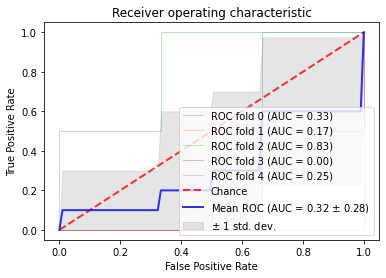

In [19]:
from sklearn.metrics import plot_roc_curve, auc, roc_curve, recall_score, confusion_matrix

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
#classifier = AdaBoostClassifier(learning_rate = 0.5, n_estimators=200)
classifier = RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100)
#classifier = MLPClassifier(random_state=1, max_iter=300)
#classifier = DecisionTreeClassifier()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# X_RF
X_s = X_train[selected_feat_rf]

# X_LASSO
# X_s = X_train[selected_feat_LASSO]

# X_PCA
# X_s = pd.DataFrame(pca_result_train)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X_s, y_train)):
    classifier.fit(X_s.iloc[train], y_train.iloc[train])
    viz = plot_roc_curve(classifier, X_s.iloc[test], y_train.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()

Cumulative explained variation for 2 principal components: 0.9821199777526503.
Cumulative explained variation for 22 principal components: 0.9999999999906216.


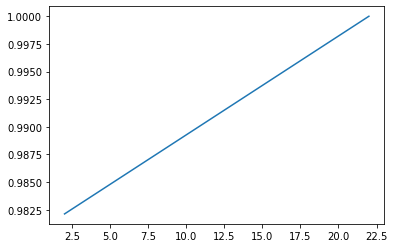

In [21]:
# feature reduction PCA
from sklearn.decomposition import PCA

n_components_list = range(2, 40, 20)
result = []
for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(X_train)
    result.append(np.sum(pca.explained_variance_ratio_))
    print(f'Cumulative explained variation for {n_components} principal components: {np.sum(pca.explained_variance_ratio_)}.')
    
plt.plot(n_components_list, result)